# Real Time Diagrammatics in QmeQ - Tutorial

This notebook contains a few examples highlighting the capabilities and usage of the RTD approach in QmeQ. The theory behind the approach is described [elsewhere](https://github.com/M-Josefsson/RTD-docs/blob/master/RTD.pdf).

## Installation

This notebook assumes that the latest version of QmeQ is installed. If not, it can be installed using

`
pip install qmeq
`

or 

`pip install --upgrade qmeq`

if an older version of qmeq is already installed.

## The RTD approach

The RTD approach provides the functionality to solve the transport problem for diagonal density matrices using the Real Time Diagrammatic technique. It is a second order  approach ($\propto\Gamma^2$, fourth order in $t$) and it can be seen as the second order extension of the Pauli approach. As such, it cannot properly handle degenerate (or almost degenerate $\Delta E\lesssim \Gamma$) states coupled to the same lead since such conditions tend to lead to off-diagonal terms in the density matrix. However, recall that different spins couple to different leads in QmeQ, so spin-degeneracy is not a problem. 

Being a second order approach means it takes into account processes such as co-tunneling, pair tunneling and energy re-normalization. It is however still perturbative in $\Gamma$ (formally in $t$) and is valid when $\hbar\Gamma\ll k_B T$. Choosing a too large $\Gamma$ can leads to unphysical artifacts, but one can generally make sure that a feature is not an artifact by checking that its magnitude scales with at most $\Gamma^2$, instead of $\Gamma^3$.


The approach is called RTD (i.e. `kerntype='pyRTD'` or `kerntype='RTD'`). It can be used in the same way as the first-order approaches, i.e. no additional parameters need to be specified. However, only `itype=1` is supported in the RTD approach, and the provided bandwidth should therefore always be a lot larger than all other energies in the problem. A larger bandwidth increases the accuracy of the results.

Furthermore, the RTD approach differs from the first order approaches in a few more ways. It does not support a matrix free method for solving the master equations, `mfreeq=True`, or the usage of symmetries `symmetry=True`. In addition, the only supported indexing type is `indexing=charge`.

We set $\hbar=e=k_b=1$ throughout this notebook.

## Auxiliary functions and imports

Before introducing the examples we'll define some functions used for calculating currents and for plotting.

In [1]:
def current(system, V, Vg, T, dT, leads=[0]):
    """Calculates current for single, and double level systems. The variable
    leads defines which leads the current is evaluated in."""
    if system.nleads==2:
        system.change( mulst={0:V/2, 1:-V/2} )
        system.change( tlst={0:T+dT, 1:T} )      
    elif system.nleads==4:
        system.change( mulst={0:V/2, 1:-V/2, 2:V/2, 3:-V/2} )
        system.change( tlst={0:T+dT, 1:T, 2:T+dT, 3:T} )
    else:
        raise ValueError('Current only defined for 2 or 4 leads.')
        
    if system.nsingle == 1:
        system.change( hsingle={(0,0):-vg} )
    elif system.nsingle == 2:
        system.change( hsingle={(0,0):-vg, (1,1):-vg} )
    else:
        raise ValueError('Current only defined for systems with nsingle = 1 or 2 .')
        
    system.solve()
    I, Q = 0, 0
    for l in leads:
        I += system.current[l]
        Q += system.heat_current[l]
    return I,Q

def generate_plot(data_x, data_y, label, color, ylabel, xlabel='Vg'):
    """Plots data_x[i] vs data_y[i]. Sets color and labels based on
    the input parameters."""
    
    xlabels = {'Vg' : r'$V_g\ [\hbar\Gamma/e]$', 'Vg_U' : r'$V_g\ [U/e]$'}
    ylabels = {'I' : r'$I\ [e\Gamma]$', 'Q' : r'$Q\ [\hbar\Gamma^2]$', 
               'Vth': r'$V_{th}\ [\hbar\Gamma/e]$', 'P': r'$P\ [\hbar\Gamma^2]$',
              'n':r'$\eta\ [\eta_C]$', 'absI':r'$|I|\ [e\Gamma]$'}
    
    for i in range(len(data_y)):
        p1 = plt.plot(data_x, data_y[i], color[i], label=label[i])
    plt.xlabel(xlabels[xlabel], size=14)
    plt.ylabel(ylabels[ylabel], size=14)
    plt.legend()

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as optimize
import qmeq

## Minimal example: single level

As a first example let's look at a single level (no spin) connected to two leads. The Hamiltonian for this case reads:

\begin{equation}
    H = H_R + H_T + H_{QD} \\
    H_R = \sum_{k,r=l,r}\omega_{k, r}c^\dagger_{k,r}c_{k, r}\\
    H_T = \sum_{k,r} t_{k, r}d^\dagger c_{k, r} + h.c. . \\
    H_{QD} = \varepsilon d^\dagger d,
\end{equation}

where $c$ denotes fermion field operators acting on the lead subspace and $d$ the QD counterparts.

We'll use both `kerntype='RTD'` and `kerntype='Pauli'` to get a comparison between the two. Non-equilibrium conditions are included using either a voltage bias or a thermal biases. First we setup our `qmeq.Builder` objects:

In [3]:
nsingle, nleads = 1, 2
hsingle = {(0,0):0}

gamma = 1
t = np.sqrt(gamma/2/np.pi)
tleads = {(0,0):t, (1,0):t}
T, V = 10*gamma, 0

system_RTD = qmeq.Builder(nsingle=nsingle, nleads=nleads, tleads=tleads, kerntype='pyRTD', itype=1, dband=1e6)
system_Pauli= qmeq.Builder(nsingle=nsingle, nleads=nleads, tleads=tleads, kerntype='Pauli', itype=1, dband=1e6)

Next we sweep the gate voltage $V_g$ (level energy)  at a fixed bias voltage $V=10\Gamma=T \ (\Delta T=0)$ and plot the results.

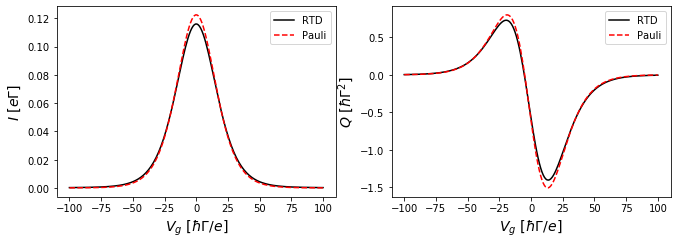

In [4]:
Vg = np.linspace(-100, 100, 200)
I_RTD, I_Pauli = np.zeros(len(Vg)), np.zeros(len(Vg))
Q_RTD, Q_Pauli = np.zeros(len(Vg)), np.zeros(len(Vg))
V = 10

for i, vg in enumerate(Vg):
    I_RTD[i], Q_RTD[i] = current(system_RTD, V, vg, T, 0)
    I_Pauli[i], Q_Pauli[i] = current(system_Pauli, V, vg, T, 0)

#Plotting
plt.figure(figsize=(11, 3.5))
f1 = plt.subplot(121)
generate_plot(Vg, [I_RTD, I_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'I', 'Vg')
plt.subplot(122)
generate_plot(Vg, [Q_RTD, Q_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'Q', 'Vg')
plt.show()

Here one can see that the second order processes make the results qualitatively different, with generally lower currents. 

Switching to a thermal bias $\Delta T = T/2$ $(V=0)$ instead of a voltage bias we get:

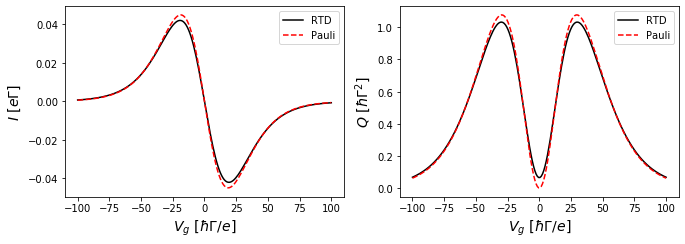

In [5]:
dT = T/2

for i, vg in enumerate(Vg):
    I_RTD[i], Q_RTD[i] = current(system_RTD, 0, vg, T, dT)
    I_Pauli[i], Q_Pauli[i] = current(system_Pauli, 0, vg, T, dT)

#Plotting
plt.figure(figsize=(11, 3.5))
f1 = plt.subplot(121)
generate_plot(Vg, [I_RTD, I_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'I', 'Vg')
plt.subplot(122)
generate_plot(Vg, [Q_RTD, Q_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'Q', 'Vg')
plt.show()

Second order processes allow electron transport at a finite, but small, energy window around the energy level, in contrast to first order processes where the energy of the transported electrons is always exactly equal to that of the QD state. This finite energy window leads to a finite heat current when $\mu_1=\mu_2=V_g$, as can be seen for the black line at $V_g=0$ in the right-hand side figure, something that is not possible in first order.

Although the effects of the second order corrections might seem small in these plots, they can have large consequences in certain situations, as will be seen later.

## Anderson model: co-tunneling 

Let's turn our attention to the Anderson model:

\begin{equation}
    H = H_R + H_T + H_{QD} \\
    H_R = \sum_{k,\sigma,r=l,r}\omega_{k,\sigma, r}c^\dagger_{k,\sigma,r}c_{k,\sigma, r}\\
    H_T = \sum_{k,\sigma,r} t_{k,\sigma, r}d^\dagger_{\sigma}c_{k,\sigma, r} + h.c. . \\
    H_{QD} = \sum_{\sigma=\uparrow\downarrow}\varepsilon_\sigma n_\sigma + Un_\uparrow n_\downarrow
\end{equation}

where $n_\sigma = d^\dagger_\sigma d_\sigma$. When the QD is subjected to an external magnetic field the single particle states will be Seeman-split $\Delta \varepsilon = \varepsilon_\uparrow - \varepsilon_\downarrow>0$. In that case one expects to see familiar co-tunneling lines inside the Coulomb diamond when performing measurements on QDs. Both second order approaches in QmeQ are able to capture this feature, as we will see now. However, due to the  numerical complexity of the 2nd order von Neumann approach we only demonstrate this for the RTD approach.

First we build the system.

In [6]:
def Anderson_model(kerntype, T, U, Ez):
    """Sets up an Anderson model with lead temperature
    T, interaction strength U and Seeman split Ez."""
    nsingle, nleads = 2, 4
    gamma = 1
    t = np.sqrt(gamma/2/np.pi)
    T = T
    U = U
    Ez = Ez #Seeman split 

    tlst = {0:T, 1:T, 2:T, 3:T}
    tleads = {(0,0):t, (1,0):t, (2,1):t, (3,1):t}
    coulomb = {(0,1,1,0):U}
    mulst = {0:0, 1:0, 2:0, 3:0}
    hsingle = {(0,0):0, (1,1):0}

    system = qmeq.Builder(nsingle, hsingle, coulomb,
                          nleads, tleads, mulst, tlst, 5e5,
                          kerntype=kerntype, itype=1)
    return system

#Set up the model
T, U, Ez = 10, 500, 100
system = Anderson_model('RTD', T, U, Ez)

Next we solve for the differential conductance $G=\frac{dI}{dV}$ for both $V$ and $V_g$ to be able to plot a stability diagram.

In [7]:
%%time
Vg = np.linspace(-U/2, U*3/2, 100)
V = np.linspace(-U*3/2, U*3/2, 100)
G = np.zeros((len(V), len(Vg)))
dV = 1e-3

for i, vg in enumerate(Vg):
    system.change(hsingle={(0,0):-vg -Ez/2,(1,1):-vg+Ez/2})
    for j, v in enumerate(V):      
        system.change(mulst={0:v/2+dV, 1:-v/2-dV, 2:v/2+dV, 3:-v/2-dV})
        system.solve()
        I1 = system.current[0] + system.current[2]
                  
        system.change(mulst={0:v/2-dV, 1:-v/2+dV, 2:v/2-dV, 3:-v/2+dV})
        system.solve()
        G[j,i] = (I1 - system.current[0] - system.current[2])/(2*dV)                            

Wall time: 25.7 s


When plotting the result we see large areas of finite (but small) conductance away from the zero-bias line $V=0$ in the Coulomb diamond. This is an effect of co-tunneling, which is properly captured by the RTD approach.

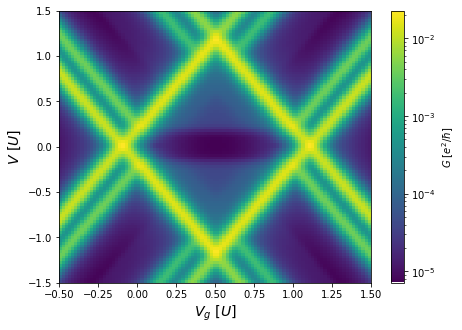

In [8]:
plt.figure(figsize=(7,5))
plt.pcolormesh(Vg/U, V/U, G, norm=matplotlib.colors.LogNorm() )
c = plt.colorbar(label=r'$G \ [e^2/{\hbar}]$')
plt.xlabel(r'$V_g\ [U]$', size=14)
plt.ylabel(r'$V\ [U]$', size=14)
plt.show()

## A larger example: the quantum dot heat engine

In order to see when it can be absolutely necessary to include second order effects we can keep studying the Anderson model. However, now we'll use the QD as a heat engine, converting thermal energy into electrical energy using the Seebeck effect. When using the QD as a heat engine it's connected in series to an external (resistive) load, instead of a voltage source, yielding the circuit diagram:

<img src='./images/QD_load.png'  width="400" height="200">

The red and blue blocks next to the QD symbolize leads at different temperatures. Due to current conservation in the circuit the same current needs to flow through both components. In addition, Krichhoff's voltage law states that the size of the voltages need to be the same over both components, but with opposite polarity. Thus, determining the operating conditions for the QD requires solving (iteratively)

\begin{equation}
    I_{QD}(V_{QD}) + \frac{V_{QD}}{R}=0,
\end{equation}

for $V_{QD}$. In the limit $R\rightarrow\infty$ the equation can be used to define the thermovoltage $V_{th}=V_{QD}\Big |_{I=0}$.

All electrical power generated by the QD will be dissipated in the load and it is evaluated as $P=IV_{QD}$. We're also interested in the thermodynamic efficiency of device

\begin{equation}
    \eta=\frac{P}{\dot{Q}_H},
\end{equation}

with $\dot{Q}_H$ denoting the heat current entering the QD from the hot side.

Before calculating the power and efficiency of the device we need to introduce functions for calculating the voltage over the QD in the presence of a load, and during open circuit conditions.

In [9]:
def func_root(v, vg, T, dT, system, R):
    I, Q = current(system, v, vg, T, dT, leads=[0,2])
    if R != np.inf:
        I += v/R
    return I

def voltage_R(vg, T, dT, system, R):
    result = optimize.root_scalar(func_root, args=(vg, T, dT, system, R), method='brentq', bracket=[-200, 200])
    return result.root

It's well-known that sequential (first order) tunneling processes often don't give accurate predictions of $V_{th}$ (i.e. $\lim_{R\rightarrow \infty}V_{QD}$) due to a tight coupling between particle and energy flow. Including also second order processes breaks this tight coupling, which can lead to drastic changes of the thermovoltage, even for seemingly small $\Gamma$s.

To see this we calculate $V_{th}$ using both `kerntype='RTD'` and `kerntype='Pauli'` for an Anderson model where $T=\Delta T = 10\hbar\Gamma$ and $U = 20T$.

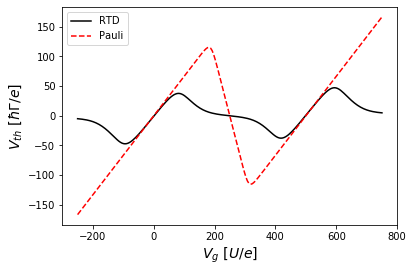

In [10]:
system_RTD = Anderson_model('RTD', T, U, 0)
system_Pauli = Anderson_model('Pauli', T, U, 0)

dT = T
Vg = np.linspace(-U/2, U*3/2, 200)
Vth_RTD, Vth_Pauli = np.zeros(len(Vg)), np.zeros(len(Vg))
for i, vg in enumerate(Vg):
    Vth_RTD[i] = voltage_R(vg, T, dT, system_RTD, np.inf)
    Vth_Pauli[i] = voltage_R(vg, T, dT, system_Pauli, np.inf)

generate_plot(Vg, [Vth_RTD, Vth_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'Vth', 'Vg_U')

Indeed, we see that including the second order processes drastically change the lineshape of $V_{th}(V_g)$.

Next, we change the load to a finite value $R=5\ M\Omega$ such that the device can generate power. We focus on the generated power and absorbed heat current as a function of $V_g$:

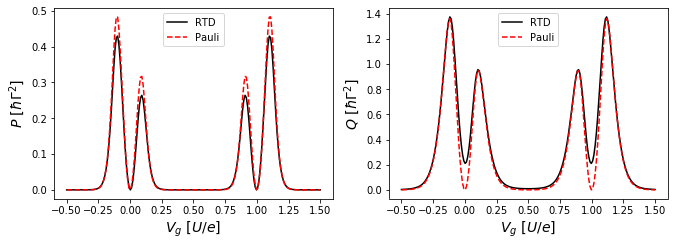

In [11]:
R = 243*5 #5 MOhm i units of hbar/e^2
I_Pauli, I_RTD = np.zeros(len(Vg)), np.zeros(len(Vg)) 
P_Pauli, P_RTD = np.zeros(len(Vg)), np.zeros(len(Vg)) 
Q_Pauli, Q_RTD = np.zeros(len(Vg)), np.zeros(len(Vg)) 

for i, vg in enumerate(Vg):
    v_Pauli = voltage_R(vg, T, dT, system_Pauli, R)
    I_Pauli[i], Q_Pauli[i] = current(system_Pauli, v_Pauli, vg, T, dT, leads=[0,2])
    P_Pauli[i] = -v_Pauli*I_Pauli[i]
    
    v_RTD = voltage_R(vg, T, dT, system_RTD, R)
    I_RTD[i], Q_RTD[i] = current(system_RTD, v_RTD, vg, T, dT, leads=[0,2])
    P_RTD[i] = -v_RTD*I_RTD[i]

#Plotting
plt.figure(figsize=(11, 3.5))
plt.subplot(121)
generate_plot(Vg/U, [P_RTD, P_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'P', 'Vg_U')
plt.subplot(122)
generate_plot(Vg/U, [Q_RTD, Q_Pauli], ['RTD', 'Pauli'], ['k', 'r--'], 'Q', 'Vg_U')

The differences between the two approaches are quite substantial, especially for the heat current, and they lead to even larger differences when calculating the efficiency:

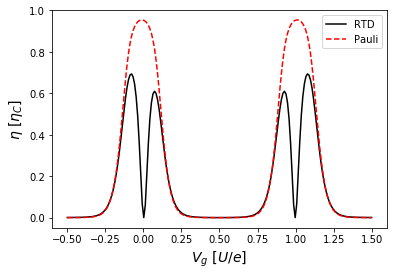

In [12]:
n_Pauli = P_Pauli/Q_Pauli
n_RTD = P_RTD/Q_RTD
nc = dT/(T+dT)

generate_plot(Vg/U, [n_RTD/nc, n_Pauli/nc], ['RTD', 'Pauli'], ['k', 'r--'], 'n', 'Vg_U')

Here we see that ignoring the second order processes leads to very large errors. The differences stem from the fact the QD can be seen as a perfect energy filter in the Pauli case (energy of transported electrons = energy of the QD state), which is no longer true when using the RTD approach. This has a large impact on $\eta$.

(The Pauli result actually gives $\eta=0$ for $V_g=0$ and $V_g=U$, but the resolution used here is too small to capture that feature.)

## Off-diagonal corrections

The RTD approach sets up Master equations for diagonal density matrices. However, when one derives these equations by performing a systematic expansion of the Liouville-von Neumann equation up to second order in $\Gamma$ one needs to include a correction term that stems from off-diagonal elements in first order. See [this article](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.78.235424) for an explanation.

These correction terms are included by default in QmeQ, but can be turned off by the user. This is done by setting the variable `off_diag_corrections` of the `qmeq.Builder` object to `False` before calling `solve()`, e.g. 

```Python
system = qmeq.Builder(..., kerntype='RTD')
system.off_diag_corrections = False
system.solve()
```

However, turning off the corrections generally does not lead to any noticeable performance gains, although it reduces memory consumption a bit.

These corrections can be important as long as first order off-diagonal terms are not identically zero (which they can be due to selection rules, e.g. in the Anderson model). They are e.g. important when more than one QD state connect to the same lead, even when the energy difference between the states is large. To illustrate this we can study a model with two states, both connected to the same two leads.

\begin{equation}
    H = H_R + H_T + H_{QD} \\
    H_R = \sum_{k,r=l,r}\omega_{k,r}c^\dagger_{k,r}c_{k, r}\\
    H_T = \sum_{k,r,i} t_{k, r, i}d^\dagger_{i}c_{k,r} + h.c. . \\
    H_{QD} = \sum_{i=1,2}\varepsilon_i d^\dagger_id_i
\end{equation}

We set up the systems using parameters where the corrections become important (in this case $T=10\Gamma$, $V=3T,\ \Delta\varepsilon = 2T,\ U = 10^4T$):

In [13]:
nsingle, nleads = 2, 2
gamma, T, V, dE, U = 1, 10, 30, 20, 1e5

coulomb = {(0,1,1,0):U}
hsingle = {(0,0):0, (1,1):dE}

t = np.sqrt(gamma/2/np.pi)
tleads = {(0,0):t, (1,0):t, (0,1):t, (1,1):t}
tlst = {0:T, 1:T}
mulst = {0:-V/2, 1:V/2}

system = qmeq.Builder(nsingle=nsingle, hsingle=hsingle, nleads=nleads, tleads=tleads, mulst=mulst,
                      coulomb=coulomb, tlst=tlst, kerntype='RTD', itype=1, dband=1e6)

Sweeping $V_g$ and plotting the current with and without the corrections shows the importance of these effects.

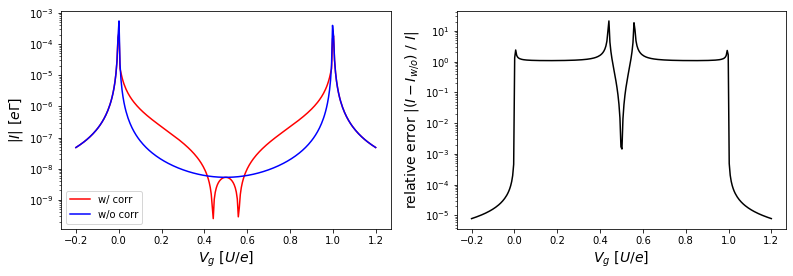

In [14]:
Vg = np.linspace(-0.2*U, 1.2*U , 300)
I1, I2 = np.zeros(len(Vg)), np.zeros(len(Vg))

for i, vg in enumerate(Vg):    
    system.change(hsingle={(0,0):-vg, (1,1):dE-vg})
    system.solve()
    I1[i] = system.current[0]
    
    system.off_diag_corrections = False
    system.solve()
    I2[i] = system.current[0]
    system.off_diag_corrections = True
    
#Plotting
plt.figure(figsize=(13,4))
plt.subplot(121)
generate_plot(Vg/U, [abs(I1), abs(I2)], ['w/ corr', 'w/o corr'], ['r', 'b'], 'absI', 'Vg_U')
plt.semilogy()

plt.subplot(122)
plt.semilogy(Vg/U, abs((I2-I1)/I1), 'k')
plt.xlabel(r'$V_g\ [U/e]$', size=14)
plt.ylabel('relative error ' + r'$\left | (I-I_{w/o})\ / \ I \right|$', size=14)
plt.show()

It's obvious that it is absolutely crucial to include the correction terms for these parameters. The relative strength of the corrections will of course depend on the model and its parameters, but it's generally recommended to keep the corrections turned on.

## Complex $t$s

The RTD approach can in general handle complex $t$s, with the exception that the energy current cannot be evaluated when the product of $t$s lead to complex matrix elements of the energy kernels. However, if one, for example, rotates all $t$s with a global complex phase one will not change the resulting currents. We exemplify this using the Anderson model

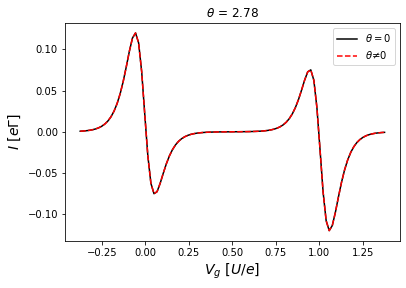

In [15]:
def rotate_tleads(g, theta):
    t = np.sqrt(g/2/np.pi)
    t2 = t*(np.cos(theta)+ 1j*np.sin(theta))
    tleads = {(0,0):t2, (1,0):t2, (2,1):t2, (3,1):t2}
    return tleads

T, dT = 10, 10
U = 400
N = 100

#Set up system and rotate tleads
system = Anderson_model('RTD', T, U, 0)
system2 = Anderson_model('RTD', T, U, 0)
theta = np.random.rand()*2*np.pi
tleads = rotate_tleads(1, theta)
system2.change(tleads = tleads)

#Sweep Vg and calculate current
Vg = np.linspace(-150, 550, N)
I, Q = np.zeros(N), np.zeros(N)
I2, Q2 = np.zeros(N), np.zeros(N)
for i, vg in enumerate(Vg):
    I[i], Q[i] = current(system, 0, vg, T, dT, leads=[0,2])
    I2[i], Q2[i] = current(system2, 0, vg, T, dT, leads=[0,2])

#Plotting
generate_plot(Vg/U, [I, I2], [r'$\theta=0$', r'$\theta\ne 0$'], ['k', 'r--'], 'I', 'Vg_U')
plt.title(r'$\theta$ = ' + str(round(theta, 2)) )
plt.show()

## Comparison with 2nd order von Neumann (2vN)

The `RTD` approach and the `2vN` approach are based on different assumptions, and they can thus model different physical processes. Both are second order approaches, but whereas `RTD` is second order in $\Gamma$, `2vN` is second order in the number of electron/hole excitations. The currents calculated using the two approaches are thus expected to differ sometimes, but will give identical results other times.

One example where they give identical results are for the an Anderson model where $U=1000\Gamma$, $T = 10\Gamma$. Below are some pre-computed results comparing the charge currents for the two approaches when sweeping either $V_g$ with a thermal bias $(\Delta T=\frac{1}{2}T, V=0)$ or sweeping $V$ with a voltage bias $(\ \Delta T = 0, V_g = 100\Gamma)$

<img src='./images/RTD_2vN_comp1.png'  width="800" height="400">
<img src='./images/RTD_2vN_comp1.png'  width="800" height="400">



## RTD with ManyBodyBuilder

In the RTD approach the energy current out from a lead is evaluated using three Kernels:

\begin{equation}
\langle J_r \rangle = \underset{D}{\text{Tr}} L_D W_r \rho_D - \frac{1}{2}\underset{D}{\text{Tr}}W_{E,1}^r\rho_D + \frac{1}{2}\underset{D}{\text{Tr}}W_{E,2}^r\rho_D
\end{equation}

The kernels in the two right-most terms depend on both the usual *many body* tunneling amplitudes in `Tba` as well as the pure *single particle* tunneling amplitudes defined in `tleads`. Therefore, using the RTD approach together with`qmeq.ManyBodyBuilder` can lead to incorrect evaluation of the energy- and heat currents as no single particle tunneling amplitudes are defined, and the last two terms are simply ignored. This is no problem in models where each single particle state only connects to a *single* lead, since the kernels contain terms proportional to $t_{l,r}t_{l,r'}$ where $l$ denotes a single particle state and $r,\ r'$ two *different* leads.

If that is not the case also single particle tunneling amplitudes have to be added when using the `ManyBodyBuilder`. We exemplify this by looking at a model with two single particle states that are hybridized. We include two leads and both states couple to both leads.

\begin{equation}
    H = H_R + H_T + H_{QD} \\
    H_R = \sum_{k,r=l,r}\omega_{k,r}c^\dagger_{k,r}c_{k, r}\\
    H_T = \sum_{k,r,i} t_{k, r, i}d^\dagger_{i}c_{k,r} + h.c. . \\
    H_{QD} = \sum_{i=1,2}\varepsilon_i d^\dagger_id_i + \sum_{i\ne j}\Omega_{ij}d^\dagger_i d_j
\end{equation}

We first build our model using `qmeq.Builder` to be able obtain many-body tunnel matrix elements and a diagonalized QD Hamiltonian:

In [16]:
#lead parameters
nleads = 2
mulst = [0, 0]
tlst = [20, 10]
t = 1/np.sqrt(2*np.pi)
tleads_ref = {(0, 0): t, (0,1):t/10, (1, 1): t, (1,0):t/10}

#QD parameters
nsingle = 2
Omega, U = 5, 500
coulomb = {(0,1,1,0):U}
hsingle = {(0,0):0, (1,1):0, (0,1):Omega}

#Setup reference system and soolve once
system_ref = qmeq.Builder(nsingle=nsingle, nleads=nleads, hsingle=hsingle, mulst=mulst, coulomb=coulomb,
                      tlst=tlst, tleads=tleads_ref, dband=5e5, kerntype='RTD', itype=1)
system_ref.solve()
print('Many-body energies: ', system_ref.Ea, '\n')
print('Many-body tunneling:\n ', system_ref.Tba)

Many-body energies:  [  0.  -5.   5. 500.] 

Many-body tunneling:
  [[[ 0.        +0.j  0.25388531+0.j  0.31030427+0.j  0.        +0.j]
  [ 0.25388531-0.j  0.        +0.j  0.        +0.j -0.31030427+0.j]
  [ 0.31030427-0.j  0.        +0.j  0.        +0.j  0.25388531+0.j]
  [ 0.        +0.j -0.31030427-0.j  0.25388531-0.j  0.        +0.j]]

 [[ 0.        +0.j -0.25388531+0.j  0.31030427+0.j  0.        +0.j]
  [-0.25388531-0.j  0.        +0.j  0.        +0.j -0.31030427+0.j]
  [ 0.31030427-0.j  0.        +0.j  0.        +0.j -0.25388531+0.j]
  [ 0.        +0.j -0.31030427-0.j -0.25388531-0.j  0.        +0.j]]]


For convenience we define a function for looping over $V_g$ and calculating the energy current for the two methods of building the system:

In [17]:
def loop_energy_current(sys, MB=False):
    """Loops Vg and calculates E. If MB=True it is assumed that
    the ManyBodyBuilder was used."""
    I = []
    for vg in Vg:
        if MB is True:
            sys.Ea = np.array([0, -vg-Omega, -vg+Omega, U-2*vg])
            sys.si.states_changed = True
            sys.solve(qdq=False, rotateq=False)
        else:
            sys.change(hsingle = {(0,0):-vg, (1,1):-vg, (0,1):Omega})
            sys.solve()
        I.append(sys.energy_current[0])        
    return I    

Vg = np.linspace(-200,U + 200, 100)

Next we see what happens if we use `qmeq.ManyBodyBuilder()` without specifying single particle tunneling. We plot the absolute value of the relative error with respect to the reference $\varepsilon= |(I_{MB}-I_{ref})/I_{ref}|$.

*Note that when using `qmeq.BuilderManyBody` we need to create the system using `pyRTD` and then change the kernel to `RTD`. This is due to a bug in the current version of the `RTD` approach. This will be fixed in later versions.*

Warning! No single particle tunneling amplitudes (tleads) detected. Corrections to the energy current in the RTD approach uses tleads. Please specify BuilderManyBody.tleads_array and BuilderManyBody.nsingle, if possible.

The correction terms can be neglected if no single particle state is connected to more than one lead.


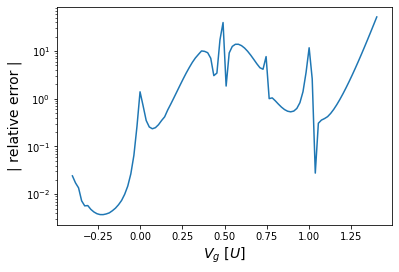

In [18]:
#Setup MB system
MB_charge = [0,1,1,2] #Charge of many body states
system1 = qmeq.BuilderManyBody(system_ref.qd.Ea, MB_charge, system_ref.Tba, mulst, tlst, 5e5, 
                               kerntype='RTD', itype=1)
system1.kerntype='RTD'

#Calculate reference and many body energy currents
I_ref = loop_energy_current(system_ref)
I1 = loop_energy_current(system1, MB = True)

#Plotting
plt.semilogy(Vg/U, abs((np.array(I_ref) - np.array(I1))/np.array(I_ref)))
plt.ylabel('| relative error |', size=14)
plt.xlabel(r'$V_g\ [U]$', size=14)
plt.show()

Here it is obvious that we make mistakes when calculating the energy current. The magnitude of the error will of course depend on the model and its parameters.

We'll therefore add single particle tunneling amplitudes to the ManyBodyBuilder system. This requires specifying `ManyBodyBuilder.nsingle` and `ManyBodyBuilder.tleads_array` where `tleads_array` is an `nleads*nsingle` array.

When specifying `tleads_array` we need to choose a single particle basis. We'll exemplify this by using both the same basis as for the reference system (see above), and the bonding/anti-bonding (molecule) basis. For the former we have already defined the $t$s in `tleads`. For the latter we need to rotate `tleads` to the new basis.

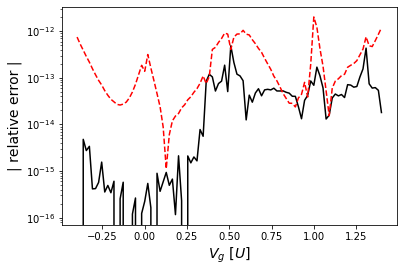

In [19]:
#Define the two systems
system2 = qmeq.BuilderManyBody(system_ref.qd.Ea, MB_charge, system_ref.Tba, mulst, tlst, 5e5, 
                               kerntype='pyRTD', itype=1)
system2.kerntype = 'RTD'

system3 = qmeq.BuilderManyBody(system_ref.qd.Ea, MB_charge, system_ref.Tba, mulst, tlst, 5e5, 
                               kerntype='pyRTD', itype=1)
system3.kerntype = 'RTD'

#Rotate tleads for bonding/anti-bonding basis
f1 = 0.6363961030854391
f2 = 0.7778174593127221
tleads_bond = {(0, 0): t*f1, (0,1):t*f2, (1, 1): t*f2, (1,0):-t*f1}

#Translate tleads to arrays
tleads_array2 = np.zeros((2,2), dtype=complex)
tleads_array3 = np.zeros((2,2), dtype=complex)
for i in range(2):
    for j in range(2):
        tleads_array2[i,j] = tleads_ref[(i,j)]
        tleads_array3[i,j] = tleads_bond[(i,j)]
        
#Set single particle tunneling and calculate energy currents
system2.nsingle = 2
system3.nsingle = 2
system2.tleads_array = tleads_array2
system3.tleads_array = tleads_array3
I2 = loop_energy_current(system2, MB = True)
I3 = loop_energy_current(system3, MB = True)

#Plotting
plt.semilogy(Vg/U, abs((np.array(I_ref) - np.array(I2))/np.array(I_ref)), 'k')
plt.semilogy(Vg/U, abs((np.array(I_ref) - np.array(I3))/np.array(I_ref)),'r--')
plt.ylabel('| relative error |', size=14)
plt.xlabel(r'$V_g\ [U]$', size=14)
plt.show()

Here we can see that both basis choices give (approximately) the same error, which is many orders of magnitude smaller than for the case without single particle tunneling.